# BO with `ax_platform=0.4.3`

install with `pip install ax-platform==0.4.3`

In [57]:
import asyncio
import random

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from ax.core.observation import ObservationFeatures
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from botorch.acquisition import qNegIntegratedPosteriorVariance
from botorch.models.gp_regression import SingleTaskGP


class ZReader:
    """A synthetic response object simulating a noisy Gaussian-like surface as the objective.
    In reality you would replace with your actual objective. 
    
    E.g., for solar cells, you could seek to optimize the cell's measured
    open-circuit voltage as a function of its chemistry. 
    """
    
    def __init__(self, centers, sigma=0.1, n_samples=1):
        """
        Initialize the Gaussian response surface.

        Args:
            centers (list): The "peak" of the Gaussian for each parameter.
            sigma (float): Spread of the Gaussian.
            n_samples (int): Number of samples to simulate measurement noise.
        """
        self.centers = np.array(centers)
        self.sigma = sigma
        self.n_samples = n_samples

    def read(self, params):
        """
        Compute the objective value (mean and SEM if multiple samples).

        Args:
            params (list): Parameter values at which to evaluate.
        Returns:
            tuple: (mean, sem) representing the evaluated objective and its SEM.
        """
        params = np.array(params)
        # Gaussian-like function
        z = np.exp(-np.sum((params - self.centers) ** 2) / (2 * self.sigma**2))
        if self.n_samples > 1:
            # Add noise for multiple samples and compute mean and SEM
            noisy_z = [
                z + np.random.normal(0, self.sigma) for _ in range(self.n_samples)
            ]
            mean_z = np.mean(noisy_z)
            sem_z = np.std(noisy_z) / np.sqrt(self.n_samples)
            return mean_z, sem_z
        return z, 0.0


async def get_next_batch_async(ax_client, batch_size):
    """Asynchronously request the next batch of trials from AxClient."""
    loop = asyncio.get_event_loop()
    return await asyncio.gather(
        *[
            loop.run_in_executor(None, ax_client.get_next_trial)
            for _ in range(batch_size)
        ]
    )


async def complete_trial_async(ax_client, trial_index, result):
    """Asynchronously mark a given trial as completed with results."""
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(
        None, ax_client.complete_trial, trial_index, result
    )


async def bayesian_optimizer_iterator_async(
    z_reader,
    param_names,
    param_bounds,
    num_initial_samples=10,
    trial_budget=20,
    batch_size=1,
    explore_ratio=0.1,
    threshold=None,
    epsilon=0.0,
    patience=10,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(
                model=Models.GPEI, num_trials=-1, max_parallelism=batch_size
            ),
        ]
    )

    ax_client = AxClient(generation_strategy=generation_strategy, torch_device=device)
    ax_client.generation_strategy.trials_as_df
    ax_client.create_experiment(
        name="modular_iterator_optimization",
        parameters=[
            {"name": name, "type": "range", "bounds": bounds}
            for name, bounds in zip(param_names, param_bounds)
        ],
        objectives={"z": ObjectiveProperties(minimize=False)},
        parameter_constraints=[],
        tracking_metric_names=[],
    )

    best_value = float("-inf")
    no_improvement_count = 0

    # Generate initial Sobol samples
    trials = await get_next_batch_async(ax_client, num_initial_samples)
    for params, trial_index in trials:
        yield params  # yield parameter dictionary
        z_mean, z_sem = z_reader.read([params[name] for name in param_names])
        await complete_trial_async(ax_client, trial_index, {"z": (z_mean, z_sem)})
        if z_mean > best_value:
            best_value = z_mean
            no_improvement_count = 0

    last_best_value = best_value

    steps_taken = 0
    while steps_taken < trial_budget:
        current_batch_size = min(batch_size, trial_budget - steps_taken)

        # Decide if we explore (qNIPV) or exploit (GPEI)
        explore = np.random.rand() < explore_ratio
        if explore:
            print("~ Using qNIPV (Exploration)")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 50},
            }
        else:
            print("$ Using GPEI (Exploitation)")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
            ax_client.generation_strategy._steps[-1].model_kwargs = {}

        trials = await get_next_batch_async(ax_client, current_batch_size)
        for params, trial_index in trials:
            yield params  # yield parameter dictionary
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            await complete_trial_async(ax_client, trial_index, {"z": (z_mean, z_sem)})

            # Check improvement
            if z_mean > best_value:
                best_value = z_mean
                # Reset patience only if we are in exploitation mode
                if not explore:
                    no_improvement_count = 0
            else:
                # If exploitation step and no improvement >= epsilon
                if not explore and best_value - last_best_value < epsilon:
                    no_improvement_count += 1

            last_best_value = best_value

            # Early stopping checks
            if threshold is not None and best_value > threshold:
                print("Stopping early: threshold exceeded.")
                # Yield the final model and stop
                yield {"final_model": ax_client.generation_strategy.model}
                return

            if not explore and no_improvement_count > patience:
                print(
                    "Stopping early: no sufficient improvement in exploitation steps."
                )
                # Yield the final model and stop
                yield {"final_model": ax_client.generation_strategy.model}
                return

        steps_taken += 1
        if steps_taken == trial_budget:
            print(f"Trial budget met")

    # If we exit the loop naturally, yield the final model
    yield {"final_model": ax_client.generation_strategy.model}


def bayesian_optimizer_iterator_sync(
    z_reader,
    param_names,
    param_bounds,
    num_initial_samples=10,
    trial_budget=20,
    batch_size=1,
    explore_ratio=0.1,
    threshold=None,
    epsilon=0.0,
    patience=10,
):
    """
    A synchronous version of the Bayesian optimization iterator with early stopping.
    Also yields the final model at the end.

    Args:
        z_reader: Object with a .read() method returning (mean, sem).
        param_names (list): Parameter names.
        param_bounds (list): Parameter bounds as (min, max).
        num_initial_samples (int): Number of initial Sobol samples.
        trial_budget (int): Maximum number of BO steps.
        batch_size (int): Trials per batch.
        explore_ratio (float): Probability of switching to qNIPV exploration.
        threshold (float or None): If best observed value > threshold, stop early.
        epsilon (float): Minimum absolute improvement to reset patience in exploitation steps.
        patience (int): Number of exploitation steps allowed without improvement.

    Yields:
        dict: Parameter sets suggested by the optimizer for evaluation.
              At the end, yields {"final_model": model_bridge} containing the final model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(
                model=Models.GPEI, num_trials=-1, max_parallelism=batch_size
            ),
        ]
    )

    ax_client = AxClient(generation_strategy=generation_strategy, torch_device=device)
    ax_client.create_experiment(
        name="modular_iterator_optimization_sync",
        parameters=[
            {"name": name, "type": "range", "bounds": bounds}
            for name, bounds in zip(param_names, param_bounds)
        ],
        objectives={"z": ObjectiveProperties(minimize=False)},
        parameter_constraints=[],
        tracking_metric_names=[],
    )

    best_value = float("-inf")
    no_improvement_count = 0

    # Initial Sobol samples
    for _ in range(num_initial_samples):
        params, trial_index = ax_client.get_next_trial()
        yield params
        z_mean, z_sem = z_reader.read([params[name] for name in param_names])
        ax_client.complete_trial(trial_index, {"z": (z_mean, z_sem)})
        if z_mean > best_value:
            best_value = z_mean
            no_improvement_count = 0

    last_best_value = best_value

    # Main BO loop: up to trial_budget steps
    for step in range(trial_budget):
        current_batch_size = min(batch_size, trial_budget - step)

        explore = np.random.rand() < explore_ratio
        if explore:
            print("~ Using qNIPV (Exploration)")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 50},
            }
        else:
            print("$ Using GPEI (Exploitation)")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
            ax_client.generation_strategy._steps[-1].model_kwargs = {}

        for _ in range(current_batch_size):
            params, trial_index = ax_client.get_next_trial()
            yield params
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            ax_client.complete_trial(trial_index, {"z": (z_mean, z_sem)})

            if z_mean > best_value:
                improvement = z_mean - best_value
                best_value = z_mean
                # Reset patience only if in exploitation
                if not explore:
                    no_improvement_count = 0
            else:
                # If exploitation step and no improvement >= epsilon
                if not explore:
                    if best_value - last_best_value < epsilon:
                        no_improvement_count += 1

            last_best_value = best_value

            # Early stopping checks
            if threshold is not None and best_value > threshold:
                print("Stopping early: threshold exceeded.")
                # Yield final model
                yield {"final_model": ax_client.generation_strategy.model}
                return

            if not explore and no_improvement_count > patience:
                print(
                    "Stopping early: no sufficient improvement in exploitation steps."
                )
                # Yield final model
                yield {"final_model": ax_client.generation_strategy.model}
                return
        if step == trial_budget-1:
            print(f"Trial budget met")

    # If we exit the loop naturally, yield the final model
    yield {"final_model": ax_client.generation_strategy.model}

# Running the BO


In [58]:
# Define parameter names and their respective bounds
param_names = ["a", "b"]
param_bounds = [[-1.0, 1.0], [-1.0, 1.0]]

# Initialize the synthetic function 
z_reader = ZReader(centers=[0.2, 0.1], sigma=0.1, n_samples=1)

# Storage for the optimization history
suggested_params = []
observed_z = []
best_result = {
    "params": None,
    "value": float("-inf"),
}

# Operating Mode
run_async = True # try both for fun!

# Set up BO kwargs
num_initial_samples = 20 
trial_budget = 20
batch_size = 2
explore_ratio = 0.1

# Stopping conditions
threshold = 0.999
epsilon = 0.001
patience = 20


if run_async:
    async for output in bayesian_optimizer_iterator_async(
        z_reader,
        param_names,
        param_bounds,
        num_initial_samples=num_initial_samples,
        trial_budget=trial_budget,
        batch_size=batch_size,
        explore_ratio=explore_ratio,
        threshold=threshold,
        epsilon=epsilon,
        patience=patience,
    ):
        if "final_model" in output:
            output = output["final_model"]
        else:
            # Normal params
            params = output
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            suggested_params.append(params)
            observed_z.append(z_mean)
            if z_mean > best_result["value"]:
                best_result = {"params": params, "value": z_mean}


else:
    for output in bayesian_optimizer_iterator_sync(
        z_reader,
        param_names,
        param_bounds,
        num_initial_samples=num_initial_samples,
        trial_budget=trial_budget,
        batch_size=batch_size,
        explore_ratio=explore_ratio,
        threshold=threshold,
        epsilon=epsilon,
        patience=patience,
    ):
        if "final_model" in output:
            output = output["final_model"]
        else:
            # Normal params
            params = output
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            suggested_params.append(params)
            observed_z.append(z_mean)
            if z_mean > best_result["value"]:
                best_result = {"params": params, "value": z_mean}

# collect results
results = {
    "suggested_params": suggested_params,
    "observed_z": observed_z,
    "best_result": best_result,
}

[INFO 12-15 14:48:39] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-15 14:48:39] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.
[INFO 12-15 14:48:39] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-15 14:48:39] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-15 14:48:39] ax.service.utils.instantiation: Created search sp

$ Using GPEI (Exploitation)


[INFO 12-15 14:48:42] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.648416, 'b': 0.305112}.
[INFO 12-15 14:48:42] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.648599, 'b': 0.305162}.
[INFO 12-15 14:48:42] ax.service.ax_client: Completed trial 21 with data: {'z': (5e-06, 0.0)}.
[INFO 12-15 14:48:42] ax.service.ax_client: Completed trial 20 with data: {'z': (5e-06, 0.0)}.
[INFO 12-15 14:48:42] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


$ Using GPEI (Exploitation)


[INFO 12-15 14:48:44] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.397561, 'b': 0.274813}.
[INFO 12-15 14:48:44] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.499696, 'b': -0.071664}.
[INFO 12-15 14:48:44] ax.service.ax_client: Completed trial 23 with data: {'z': (0.002569, 0.0)}.
[INFO 12-15 14:48:44] ax.service.ax_client: Completed trial 22 with data: {'z': (0.030823, 0.0)}.
[INFO 12-15 14:48:44] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


$ Using GPEI (Exploitation)


[INFO 12-15 14:48:46] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.499677, 'b': -0.073218}.
[INFO 12-15 14:48:46] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.376041, 'b': 0.223461}.
[INFO 12-15 14:48:46] ax.service.ax_client: Completed trial 24 with data: {'z': (0.002502, 0.0)}.
[INFO 12-15 14:48:46] ax.service.ax_client: Completed trial 25 with data: {'z': (0.099097, 0.0)}.
[INFO 12-15 14:48:46] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


~ Using qNIPV (Exploration)


[INFO 12-15 14:48:47] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.359511, 'b': 0.212131}.
[INFO 12-15 14:48:48] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.376039, 'b': 0.223451}.
[INFO 12-15 14:48:48] ax.service.ax_client: Completed trial 26 with data: {'z': (0.14944, 0.0)}.
[INFO 12-15 14:48:48] ax.service.ax_client: Completed trial 27 with data: {'z': (0.099114, 0.0)}.
[INFO 12-15 14:48:48] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


$ Using GPEI (Exploitation)


[INFO 12-15 14:48:49] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.359525, 'b': 0.212139}.
[INFO 12-15 14:48:51] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.349127, 'b': 0.139742}.
[INFO 12-15 14:48:51] ax.service.ax_client: Completed trial 29 with data: {'z': (0.303943, 0.0)}.
[INFO 12-15 14:48:51] ax.service.ax_client: Completed trial 28 with data: {'z': (0.149395, 0.0)}.
[INFO 12-15 14:48:51] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


$ Using GPEI (Exploitation)


[INFO 12-15 14:48:53] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.253531, 'b': 0.151397}.
[INFO 12-15 14:48:54] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.346752, 'b': 0.245831}.
[INFO 12-15 14:48:54] ax.service.ax_client: Completed trial 31 with data: {'z': (0.117638, 0.0)}.
[INFO 12-15 14:48:54] ax.service.ax_client: Completed trial 30 with data: {'z': (0.759298, 0.0)}.
[INFO 12-15 14:48:54] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


$ Using GPEI (Exploitation)


[INFO 12-15 14:48:56] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.226041, 'b': 0.086526}.
[INFO 12-15 14:48:56] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.253432, 'b': 0.1514}.
[INFO 12-15 14:48:56] ax.service.ax_client: Completed trial 32 with data: {'z': (0.957926, 0.0)}.
[INFO 12-15 14:48:56] ax.service.ax_client: Completed trial 33 with data: {'z': (0.759689, 0.0)}.
[INFO 12-15 14:48:56] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


$ Using GPEI (Exploitation)


[INFO 12-15 14:48:58] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.205677, 'b': 0.146062}.
[INFO 12-15 14:48:58] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.191425, 'b': 0.040326}.
[INFO 12-15 14:48:58] ax.service.ax_client: Completed trial 34 with data: {'z': (0.897901, 0.0)}.
[INFO 12-15 14:48:58] ax.service.ax_client: Completed trial 35 with data: {'z': (0.833831, 0.0)}.
[INFO 12-15 14:48:58] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


$ Using GPEI (Exploitation)


[INFO 12-15 14:48:59] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.216135, 'b': 0.094376}.
[INFO 12-15 14:49:00] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.214789, 'b': 0.000119}.
[INFO 12-15 14:49:00] ax.service.ax_client: Completed trial 37 with data: {'z': (0.600647, 0.0)}.
[INFO 12-15 14:49:00] ax.service.ax_client: Completed trial 36 with data: {'z': (0.985507, 0.0)}.
[INFO 12-15 14:49:00] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


$ Using GPEI (Exploitation)


[INFO 12-15 14:49:01] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.216134, 'b': 0.094376}.
[INFO 12-15 14:49:02] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.194407, 'b': 0.099905}.
[INFO 12-15 14:49:02] ax.service.ax_client: Completed trial 38 with data: {'z': (0.985509, 0.0)}.
[INFO 12-15 14:49:02] ax.service.ax_client: Completed trial 39 with data: {'z': (0.998437, 0.0)}.
[INFO 12-15 14:49:02] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


~ Using qNIPV (Exploration)


[INFO 12-15 14:49:02] ax.service.ax_client: Generated new trial 40 with parameters {'a': 0.199646, 'b': 0.099962}.
[INFO 12-15 14:49:02] ax.service.ax_client: Generated new trial 41 with parameters {'a': 0.177744, 'b': 0.101112}.
[INFO 12-15 14:49:02] ax.service.ax_client: Completed trial 41 with data: {'z': (0.975478, 0.0)}.
[INFO 12-15 14:49:02] ax.service.ax_client: Completed trial 40 with data: {'z': (0.999994, 0.0)}.


Stopping early: threshold exceeded.


# Printing the Best Result

In [59]:
# real peak @ 1 = (0.2, 0.1)
results['best_result']

{'params': {'a': 0.19964616116809264, 'b': 0.09996249282690162},
 'value': 0.9999936695846872}

# Visualizing of the Result

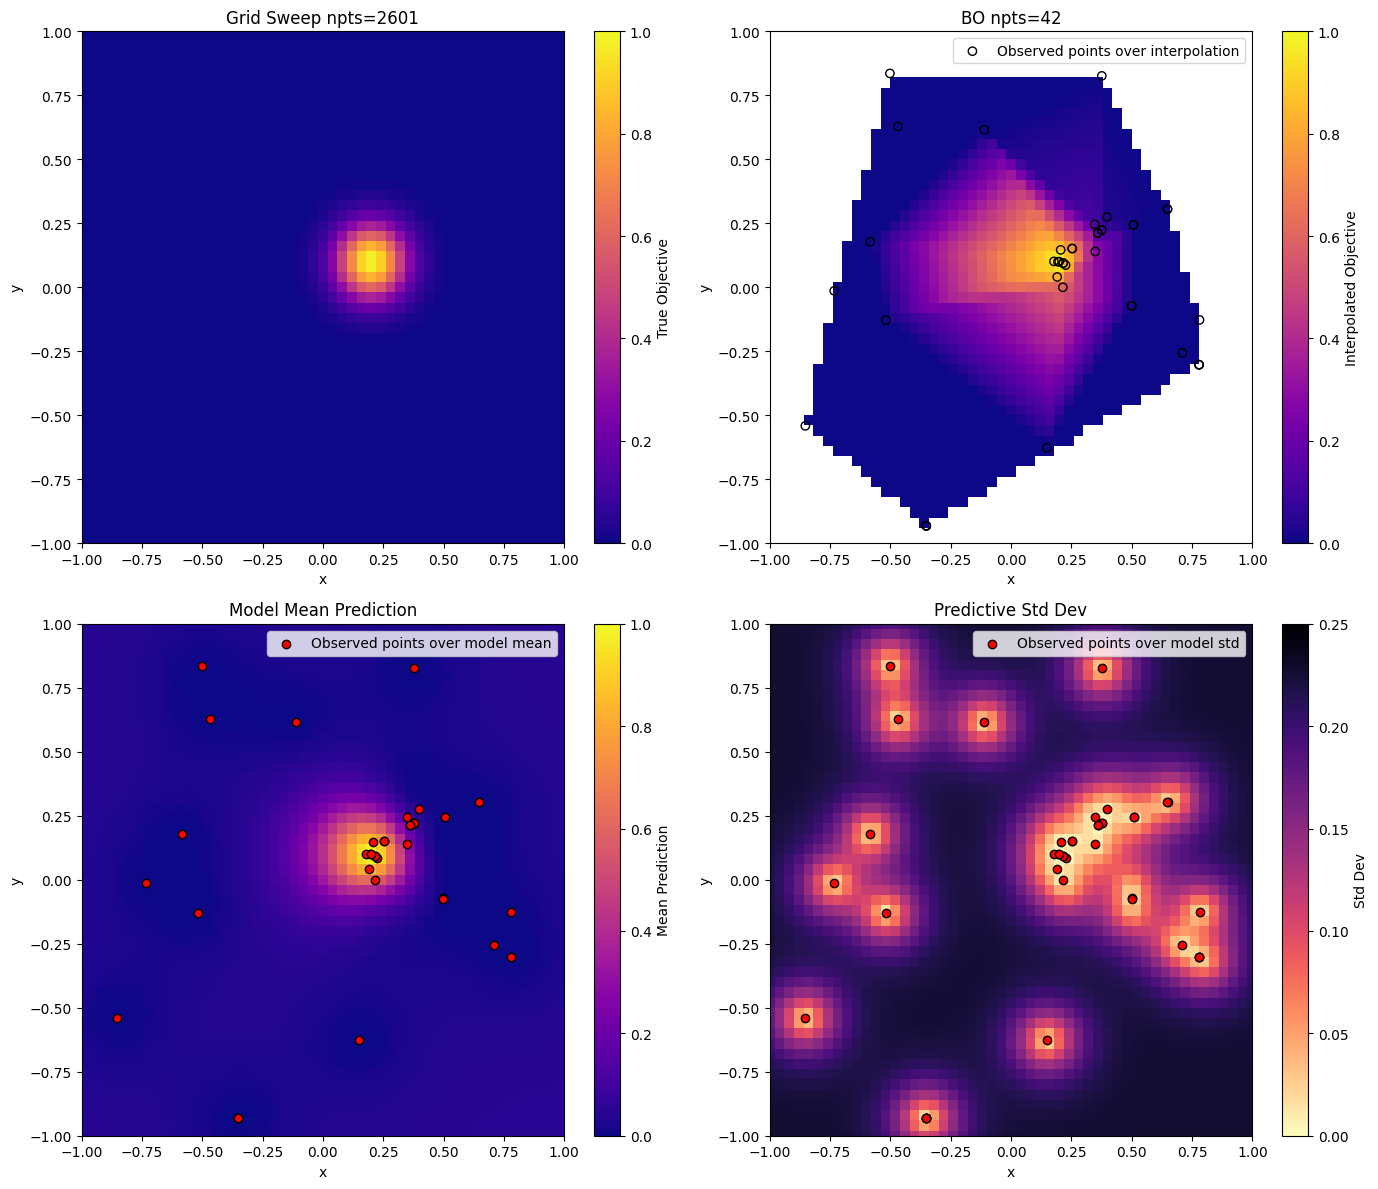

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from ax.core.observation import ObservationFeatures

# --- Extract observed x, y, and z values ---
x_vals = [p[param_names[0]] for p in results["suggested_params"]]
y_vals = [p[param_names[1]] for p in results["suggested_params"]]

# --- Grid Sweep: True Objective Function ---
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = np.exp(-((x_grid - 0.2) ** 2 + (y_grid - 0.1) ** 2) / (2 * 0.1**2))

# --- Interpolated Surface ---
x_interp_grid, y_interp_grid = np.meshgrid(x, y)
z_interp = griddata((x_vals, y_vals), observed_z, (x_interp_grid, y_interp_grid), method="linear")

# --- Model Predictions (Mean and Std Dev) ---
# Prepare grid for evaluation
mesh = np.column_stack([x_grid.ravel(), y_grid.ravel()])

# Convert grid points to Ax-compatible observation features
observation_features = [
    ObservationFeatures(parameters={param_names[0]: float(x_val), param_names[1]: float(y_val)})
    for x_val, y_val in mesh
]

# Predict using the model
mean_dict, cov_dict = output.predict(observation_features)

# Extract mean and covariance
mean_z = np.array(mean_dict["z"])
cov_z = np.array(cov_dict["z"]["z"])

# Compute variance and standard deviation
var = cov_z if cov_z.ndim == 1 else np.diag(cov_z)
std = np.sqrt(var)

# Reshape predictions to grid
f_mean_grid = mean_z.reshape(x_grid.shape)
f_std_grid = std.reshape(x_grid.shape)

# --- Plot Results in a 2x2 Grid ---
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: True Objective (Grid Sweep)
c1 = ax[0, 0].pcolormesh(x_grid, y_grid, z_grid, shading="auto", cmap="plasma", vmin=0, vmax=1)
ax[0, 0].set_title("Grid Sweep npts=2601")
ax[0, 0].set_xlabel("x")
ax[0, 0].set_ylabel("y")
ax[0, 0].set_xlim(-1,1)
ax[0, 0].set_ylim(-1,1)
fig.colorbar(c1, ax=ax[0, 0], label="True Objective")

# Plot 2: Interpolated Surface with Observed Points
c2 = ax[0, 1].pcolormesh(x_interp_grid, y_interp_grid, z_interp, shading="auto", cmap="plasma", vmin=0, vmax=1)
ax[0, 1].scatter(x_vals, y_vals, edgecolor="black", facecolor="none", label="Observed points over interpolation")
ax[0, 1].set_title(f"BO npts={len(x_vals)}")
ax[0, 1].set_xlabel("x")
ax[0, 1].set_ylabel("y")
ax[0, 1].legend(loc="upper right")
ax[0 ,1].set_xlim(-1,1)
ax[0 ,1].set_ylim(-1,1)
fig.colorbar(c2, ax=ax[0, 1], label="Interpolated Objective")

# Plot 3: Model Mean Prediction
c3 = ax[1, 0].pcolormesh(x_grid, y_grid, f_mean_grid, shading="auto", cmap="plasma", vmin=0, vmax=1)
ax[1, 0].scatter(x_vals, y_vals, edgecolor="black", facecolor="red", label="Observed points over model mean")
ax[1, 0].set_title("Model Mean Prediction")
ax[1, 0].set_xlabel("x")
ax[1, 0].set_ylabel("y")
ax[1 ,0].set_xlim(-1,1)
ax[1 ,0].set_ylim(-1,1)
ax[1, 0].legend(loc="upper right")
fig.colorbar(c3, ax=ax[1, 0], label="Mean Prediction")

# Plot 4: Model Predictive Standard Deviation
c4 = ax[1, 1].pcolormesh(x_grid, y_grid, f_std_grid, shading="auto", cmap="magma_r", vmin=0, vmax=.25)
ax[1, 1].scatter(x_vals, y_vals, edgecolor="black", facecolor="red", label="Observed points over model std")
ax[1, 1].set_title("Predictive Std Dev")
ax[1, 1].set_xlabel("x")
ax[1, 1].set_ylabel("y")
ax[1 ,1].set_xlim(-1,1)
ax[1 ,1].set_ylim(-1,1)
ax[1, 1].legend(loc="upper right")
fig.colorbar(c4, ax=ax[1, 1], label="Std Dev")

# Adjust layout and show
plt.tight_layout()
plt.show()


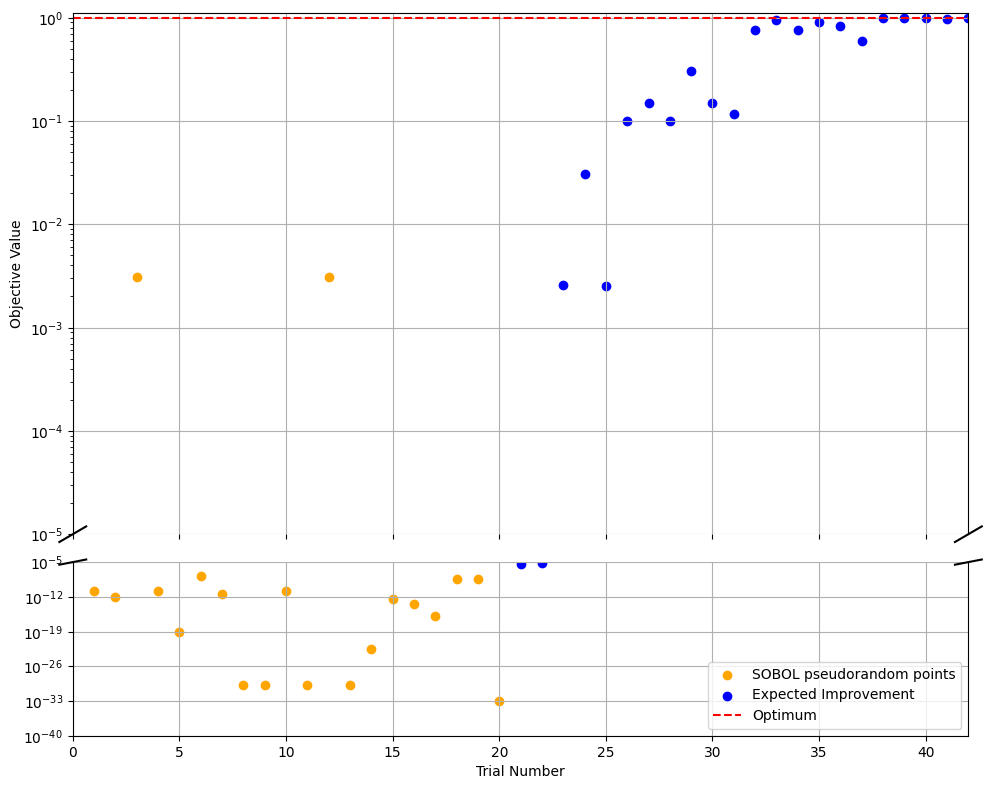

In [61]:
import matplotlib.pyplot as plt

# Data preparation
trial_numbers = list(range(1, len(observed_z) + 1))  # Create trial numbers starting from 1
num_initial_samples = 20
random_trials = trial_numbers[:num_initial_samples]
random_objectives = observed_z[:num_initial_samples]
bo_trials = trial_numbers[num_initial_samples:]
bo_objectives = observed_z[num_initial_samples:]

# Create the figure and two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot the initial random points on both axes
ax1.scatter(random_trials, random_objectives, color='orange', label="SOBOL pseudorandom points")
ax2.scatter(random_trials, random_objectives, color='orange', label="SOBOL pseudorandom points")

# Plot Bayesian optimization points on both axes
ax1.scatter(bo_trials, bo_objectives, marker='o', linestyle='-', color='b', label="Expected Improvement")
ax2.scatter(bo_trials, bo_objectives, marker='o', linestyle='-', color='b', label="Expected Improvement")

# Highlight the optimum on both axes
ax1.axhline(y=1, color='r', linestyle='--', label="Optimum")
ax2.axhline(y=1, color='r', linestyle='--', label="Optimum")

# Set y-limits for each axis
ax1.set_ylim(1e-5, 1.1e0)  # Top split
ax2.set_ylim(1e-40, 1e-5)  # Bottom split
ax1.set_yscale("log")
ax2.set_yscale("log")

# Hide the spines between the two y-axes
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # Disable tick labels at the bottom of ax1
ax2.tick_params(labeltop=False)  # Disable tick labels at the top of ax2

# Add diagonal lines to indicate the split
d = 0.015  # Size of the diagonal line
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal
kwargs.update(transform=ax2.transAxes)  # Apply the same to ax2
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

# Labels, legend, and grid
ax2.set_xlabel("Trial Number")
ax1.set_ylabel("Objective Value")
# ax2.set_ylabel("Objective Value")
# ax1.legend(loc="upper right")
ax2.legend(loc="lower right")
ax1.grid(True)
ax2.grid(True)

ax1.set_xlim(0, len(bo_trials + random_trials))

plt.tight_layout()
plt.show()
